# Accessing Multisprectral Satellite Imagery from Copernicus Data Space Ecosystem CDCE via API

Run this cell to ensure you have all required dependencies/versions in you virtual environment:

In [ ]:
%pip install -r ../../requirements.txt

The Sentinel Hub API is a RESTful API interface that provides access to various satellite imagery archives. It allows you to access raw satellite data, rendered images, statistical analysis, and other features. 

To use the features in this notebook you need to visit https://dataspace.copernicus.eu and create an account with Copernicus, the official governing body of Sentinel Missions for the European Space Agency (ESA). This takes about 5 minutes to do.

In [ ]:
import os
import kagglehub
import sys
import json

from sentinelhub import (SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)
from utils import plot_image
from dotenv import load_dotenv
import requests_oauthlib as requests
import matplotlib.pyplot as plt
import numpy as np
import datetime 
import pandas as pd
from PIL import Image

# FIRST TIME Credentials

If you are using colab, refer to [this]("https://www.googlecloudcommunity.com/gc/Community-Hub/How-do-I-add-secrets-in-Google-Colab-Enterprise/m-p/784866") on where to save your secrets. <br> This notebook was created in a local IDE but should work in any python interface, but might need minor adjustments. <br><br>
Run the following cells the first time you run this notebook after retrieving your credentials for CDSE from their website. The `client_id` & `client_secret` can be obtained in your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the User Settings you can create a new OAuth Client to generate these credentials. For more detailed instructions, visit the relevant [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, save them in the .env file in the same directory as this script, 
by simply inserting the following lines:

CLIENT_ID= "your_client_id"
CLIENT_SECRET= "your_client_secret"

For privacy and security please make sure that ".env" is included in your .gitignore file
Once this is all done, you can proceed from here:

In [32]:
load_dotenv() 

config = SHConfig(use_defaults=True)
config.sh_client_id = os.getenv("CLIENT_ID")
config.sh_client_secret = os.getenv("CLIENT_SECRET")
config.sh_token_url = os.getenv("TOKEN_URL")
config.sh_base_url = os.getenv("BASE_URL")
config.save("cdse")

Check that the complete config has also been stored on your local machine for future use,
this ensures everything is set correctly and that you can use your cedentials with other 
virtual machines for as long as your OAuth token is valid. 

In [33]:
SHConfig.get_config_location()

'/Users/sara_mac/.config/sentinelhub/config.toml'

This workflow works with credentials and configurations specific to the free CDSE platform, not Sentinel Hub, which requires a subscription after a 30 day free trial. 
Instructions on how to configure your Sentinel Hub Python package instead can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Using these instructions you can create a profile specific to using the Sentinel Hub package for accessing Copernicus Data Space Ecosystem data collections, if you wish to do so. 

# RETRIEVE PREVIOUS Credentials
Skip directly to this section if you have already set up the credentials in previous cells in a previous run of the notebook.

In [35]:
config = SHConfig("cdse")

In [36]:
# check that the credentials are set correctly 
if not config.sh_client_id or not config.sh_client_secret:
    print("Please provide your Sentinel Hub credentials in the .env file.")
    exit(1)

# check that the credentials are what you expect (i.e. output is the same & not None)
# NOTE: you can also set the credentials directly in the code, 
# but this is not recommended for security reasons.
# do not print the secret credentials 'id' or 'secret' in a public notebook for security reasons either
print(config.sh_token_url)
print(config.sh_base_url)

https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token
https://sh.dataspace.copernicus.eu


# Fixed bounding boxes selected for 3 Areas of Interest

Do not change the values for the selected AOIs, but add others if required.
Make sure the aoi_size is less than 2500 pixels as the maximum image length/width to request. If larger areas are needed a mosaics approach needs to be implemented and can be added at a later stage.

In [37]:
# Po River 
resolution = 10
AOI1 = 'Po River Plume'
aoi_prp =[12.45, 44.825, 12.7, 45.055]  

aoi1_bbox = BBox(bbox=aoi_prp, crs=CRS.WGS84)
aoi1_size = bbox_to_dimensions(aoi1_bbox, resolution=resolution)
print(f"Image shape for {AOI1} at {resolution} m resolution: {aoi1_size} pixels")


Image shape for Po River Plume at 10 m resolution: (2049, 2496) pixels


In [6]:
# Corsica
resolution = 10
AOI2 = 'North East Corsica'
aoi2_nec =[9.6, 42.95, 9.9, 43.155]  

aoi2_bbox = BBox(bbox=aoi2_nec, crs=CRS.WGS84)
aoi2_size = bbox_to_dimensions(aoi2_bbox, resolution=resolution)
print(f"Image shape for {AOI2} at {resolution} m resolution: {aoi2_size} pixels")

Image shape for North East Corsica at 10 m resolution: (2423, 2298) pixels


In [7]:
# Calabria
resolution = 10
AOI3 = 'South East Calabria'
aoi3_sec =[16.5, 38.35, 16.755, 38.555]  

aoi3_bbox = BBox(bbox=aoi3_sec, crs=CRS.WGS84)
aoi3_size = bbox_to_dimensions(aoi3_bbox, resolution=resolution)
print(f"Image shape for {AOI3} at {resolution}m resolution: {aoi3_size} pixels")

Image shape for South East Calabria at 10m resolution: (2185, 2314) pixels


# Download workflow 
- Match full Sentinel Catalog for S2_L1C to AOI & time period (adjust as needed, but within litterrow time period, i.e. between 01/07/2015 - 31/08/2021)
- Limit results to images with identified litter windrows
- define evalscript with bands and images to download
- Iterate through images from filtered results (i.e. with litter rows) and save them.


## Limit Catalog to products with identified & annotated litter rows

In [38]:
catalog = SentinelHubCatalog(config=config)

In [59]:
# Retrieve images from the Sentinel Hub Catalog for the specified AOI
# and time interval in representative batches

aoi_bbox = BBox(bbox=aoi_prp, crs=CRS.WGS84) # switch for aoi_nec or aoi_sec as needed
time_interval =  "2019-07-01 00:00:00", "2019-07-31 00:01:00" # adjust dates as needed with max period:
# "2015-07-01", "2021-08-31" -- total images: 3026 for prp, 754 for nec, 378 for sec

search_iterator = catalog.search(
    DataCollection.SENTINEL2_L1C,
    bbox=aoi_bbox,
    time=time_interval,
    fields={"include": ["id", "properties.datetime"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results:", len(results))


Total number of results: 48


Check if any of the id's match images with positive pixels listed in LM_centroids.xlxs

In [40]:
# Function to match LW source data to the image ID 
# Iterate through the results and check for matches by removing S2A_MSIL1C_ 
# from the 'id' and keeping only the datestr and codeT which are
# listed in the LM_centroids.xlsx file based on S2L1C naming convention: 
# S2A_MSIL1C__YYYYMMDDTXXXXXX....

def check_matching_ids(results, lm_centroids_path):
    
    lm_centroids = pd.read_excel(lm_centroids_path)
    if 'Str_time' not in lm_centroids.columns:
        raise ValueError("The column 'Str_time' is not found in the provided Excel file.")
    
    str_time_set = set(lm_centroids['Str_time'])
    
    matching_ids = []
    for result in results:
        trimmed_id = result['id'][11:26]
        if trimmed_id in str_time_set:
            matching_ids.append(result['id'])
    
    return matching_ids


lm_centroids_path = "../LM_centroids.xlsx" 
matching_ids = check_matching_ids(results, lm_centroids_path)
print("Matching IDs:", matching_ids)

Matching IDs: ['S2A_MSIL1C_20190730T100031_N0500_R122_T32TQQ_20230710T202111.SAFE', 'S2A_MSIL1C_20190730T100031_N0500_R122_T33TUK_20230710T202111.SAFE', 'S2A_MSIL1C_20190730T100031_N0500_R122_T32TQR_20230710T202111.SAFE', 'S2A_MSIL1C_20190730T100031_N0500_R122_T33TUL_20230710T202111.SAFE', 'S2B_MSIL1C_20190725T100039_N0500_R122_T32TQQ_20230619T024542.SAFE', 'S2B_MSIL1C_20190725T100039_N0500_R122_T33TUK_20230619T024542.SAFE', 'S2B_MSIL1C_20190725T100039_N0500_R122_T32TQR_20230619T024542.SAFE', 'S2B_MSIL1C_20190725T100039_N0500_R122_T33TUL_20230619T024542.SAFE', 'S2A_MSIL1C_20190723T101031_N0500_R022_T32TQQ_20230718T015529.SAFE', 'S2A_MSIL1C_20190723T101031_N0500_R022_T33TUK_20230718T015529.SAFE', 'S2A_MSIL1C_20190723T101031_N0500_R022_T32TQR_20230718T015529.SAFE', 'S2A_MSIL1C_20190723T101031_N0500_R022_T33TUL_20230718T015529.SAFE', 'S2A_MSIL1C_20190720T100031_N0500_R122_T32TQQ_20230715T235221.SAFE', 'S2A_MSIL1C_20190720T100031_N0500_R122_T33TUK_20230715T235221.SAFE', 'S2A_MSIL1C_2019072

In [41]:
print(f"{len(matching_ids)} matching images found between {time_interval[0]} and {time_interval[1]} for {AOI1}.") 
# exchange for AOI2, AOI3, as req.

24 matching images found between 2019-07-01 and 2019-07-31 for Po River Plume.


Filter images needed:

In [42]:
new_results = [
    {key: record[key] for key in record if key in ["id", "properties"]}
    for record in results if record["id"] in matching_ids
]

## Define Eval script of bands for download and how to combine the returned outputs 
(i.e. RGB image with invisible bands, FDI, NVDI, or custom false colour images)
This evalscript includes only four bands for workflow trial, but can be extended to include all bands available (as well as return calculated indexes such as NVDI). More documentation on the components and how to write/edit eval scripts can be found in the [doumentation](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript/V3.html).

Based on Booth et al. (2023) (who used Marida + PLP) the following 4 bands were selected:<br>
bands: ["B04", "B06", "B08", "B11"] , i.e. // red, red edge + NIR + SWIR
<br>
The authors reported the Map Mapper-Opt "model trained with only 4 bands (the ones contributing to calculating FDI and NDVI) demonstrated good (better) performance than using all 13 Sentinel-2 bands. However, it is possible that other band combinations could improve model performance. Removing some of the lower resolution bands, as well as bands where wavelengths do not correlate with plastic materials, may reduce noise in the data set."

Complete list of bands that can be selected from L1C are:
["B01", "B03", "B03", "B04", "B05", "B06", "B07", "B08", "B08a", "B09", "B10, "B11, "B12"]


Within the eval script the function evaluatePixel(sample) return value determines how data from the various multi spectral index (MSI) bands are handled (if multiplied by a factor for visibility & plotting - see this [very short video]("https://www.youtube.com/watch?v=02Xbbu1PHdg&t=65s") for example outputs of true colour vs different false colour combinations) <br>
<br> In this case it simple returns a list with the seperate values for each of the four selected bands.

In [60]:
evalscript_true_color = """
//VERSION=3

function setup() {
    return {
        input: [{
            bands: ["B04", "B06", "B08", "B11"] 
        }],
        output: {
            bands: 4
        }
    };
}

function evaluatePixel(sample) {
    return [sample.B04, sample.B06, sample.B08, sample.B11]; // R + RE + NIR + SWIR in seperate files
}
"""

# to change outputs saved to real true colour composites, false composites or indexes, such as NVDI & FDI 
# the function evaluatePixel(sample) return value needs to be adjusted. Pre-set evals scripts will be added for each option shortly 
# Generate requests for each matching ID
requests_true_color = []
for matching_id in matching_ids:
    request = SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                identifier=matching_id,
            time_interval=time_interval,
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=aoi_bbox, #e xchange for aoi2_bbox for Corsica , aoi3_bbox for Calabria as req.
        size=aoi1_size, # exchange for aoi2_size for Corsica , aoi3_size for Calabria as req.
        config=config,
    )
    requests_true_color.append(request)

print(f"Generated {len(requests_true_color)} requests for true color images.")

Generated 24 requests for true color images.


# Save requested products locally
 This will be phased out ASAP in favour of saving directly to a centralised kagglehub dataset
 A notebook section with the option to upload S2 images/bands already downloaded locally will be added as well.

In [ ]:
true_color_imgs = []
# Loop through each result to fetch the corresponding image

output_dir = "../data" # adjust this for kaggle dataset

for result in new_results:
    timestamp = result["properties"]["datetime"]
    result_id = result["id"] 
    print(f"Fetching image for timestamp: {timestamp}")

    # Request for a single image corresponding to the timestamp
    request_true_color = SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C.define_from(
                    name="s2l1c", service_url="https://sh.dataspace.copernicus.eu"
                ),
                time_interval=(timestamp, timestamp),  # Use specific timestamp for each result
                other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=aoi_bbox, #exchange for aoi2_bbox for Corsica , aoi3_bbox for Calabria as req.
        size=aoi1_size, #exchange for aoi2_size for Corsica , aoi3_size for Calabria as req.
        config=config,
    )

    # Get the data (the image) and append to the list
    image = request_true_color.get_data()
    
    # Since get_data() returns a list of images, take the first one
    true_color_imgs.append(image[0])  # Append the first image (or modify as needed)
    
    # Save the image to the "data" folder
    image_array = image[0]
    image_path = os.path.join(output_dir, f"{result_id}.tiff")  # Use ID for naming
    Image.fromarray(image_array).save(image_path)

    print(f"Fetched and stored image for {timestamp}")

Fetching image for timestamp: 2019-07-30T10:08:32.85Z
Fetching image for timestamp: 2019-07-30T10:08:29.669Z
Fetching image for timestamp: 2019-07-30T10:08:17.911Z
Fetching image for timestamp: 2019-07-30T10:08:15.325Z
Fetching image for timestamp: 2019-07-25T10:08:36.543Z
Fetching image for timestamp: 2019-07-25T10:08:33.367Z
Fetching image for timestamp: 2019-07-25T10:08:21.601Z
Fetching image for timestamp: 2019-07-25T10:08:19.016Z
Fetching image for timestamp: 2019-07-23T10:18:30.071Z
Fetching image for timestamp: 2019-07-23T10:18:26.259Z
Fetching image for timestamp: 2019-07-23T10:18:15.519Z
Fetching image for timestamp: 2019-07-23T10:18:11.832Z
Fetching image for timestamp: 2019-07-20T10:08:33.27Z
Fetching image for timestamp: 2019-07-20T10:08:30.09Z
Fetching image for timestamp: 2019-07-20T10:08:18.325Z
Fetching image for timestamp: 2019-07-20T10:08:15.74Z
Fetching image for timestamp: 2019-07-05T10:08:36.896Z
Fetching image for timestamp: 2019-07-05T10:08:33.718Z
Fetching image

In [51]:
len(true_color_imgs)

24

In [55]:
true_color_imgs[0].shape, true_color_imgs[1].shape, true_color_imgs[3].shape, true_color_imgs[4].shape

((2496, 2049, 4), (2496, 2049, 4), (2496, 2049, 4), (2496, 2049, 4))

# Plot bands 

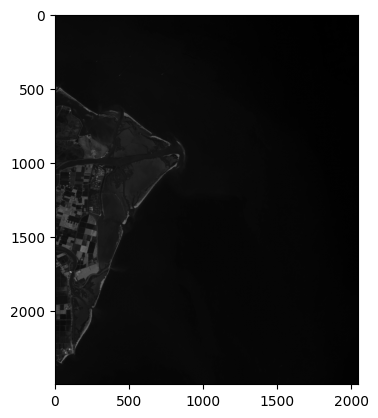

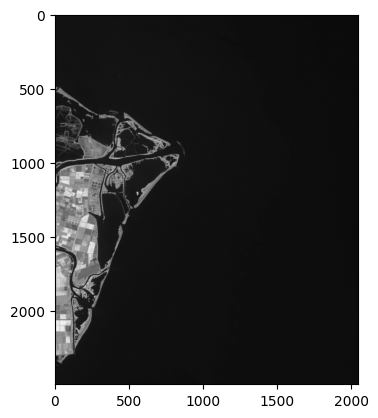

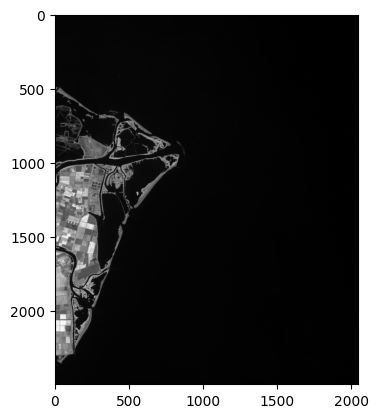

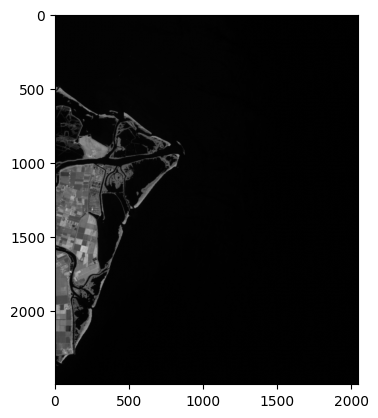

In [ ]:
for i in range(4):
    plt.imshow(true_color_imgs[0][:, :, i], cmap="gray")
    plt.show()

Image.fromarray(true_color_imgs[0][:, :, :3]).save("sample.jpg")

Image type: uint8


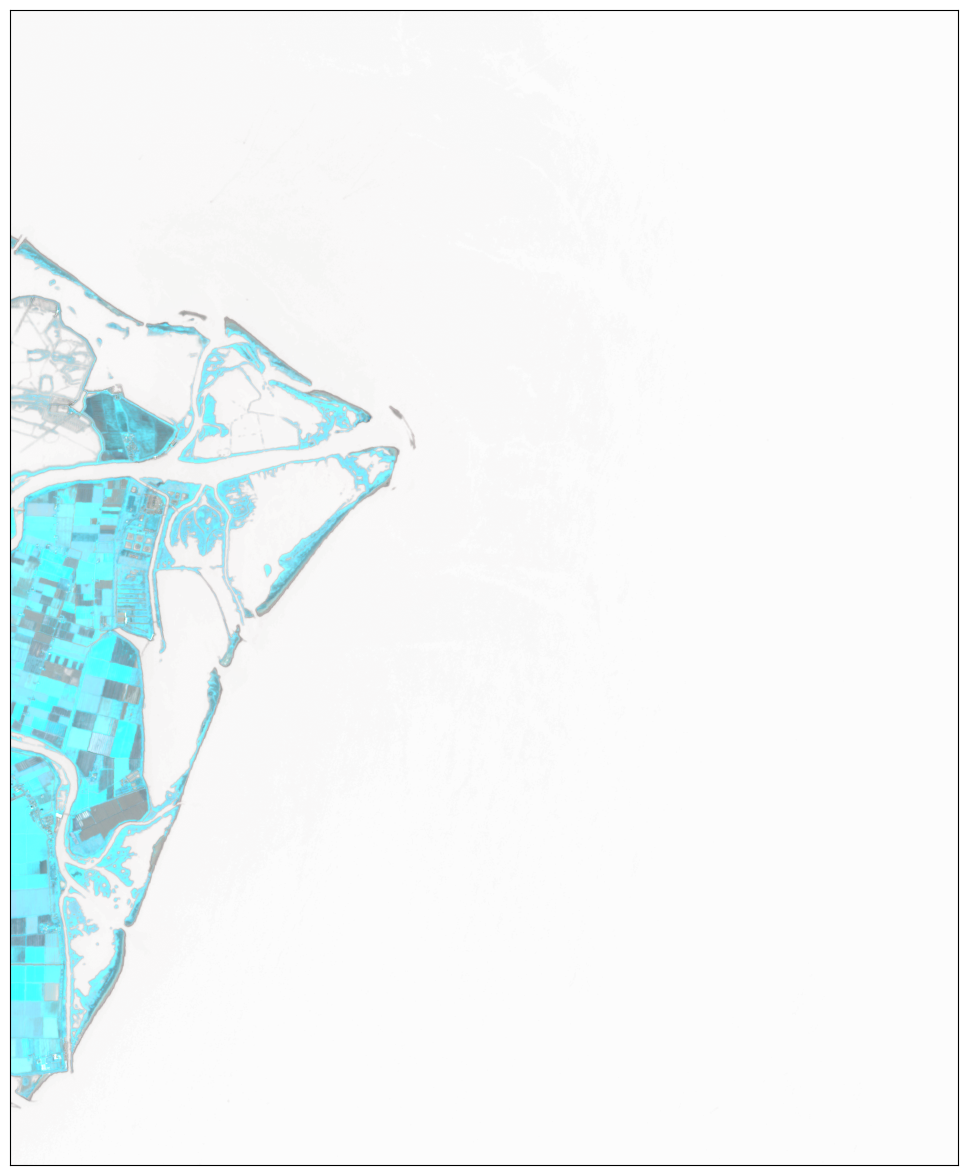

In [ ]:
from typing import Any, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np

def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

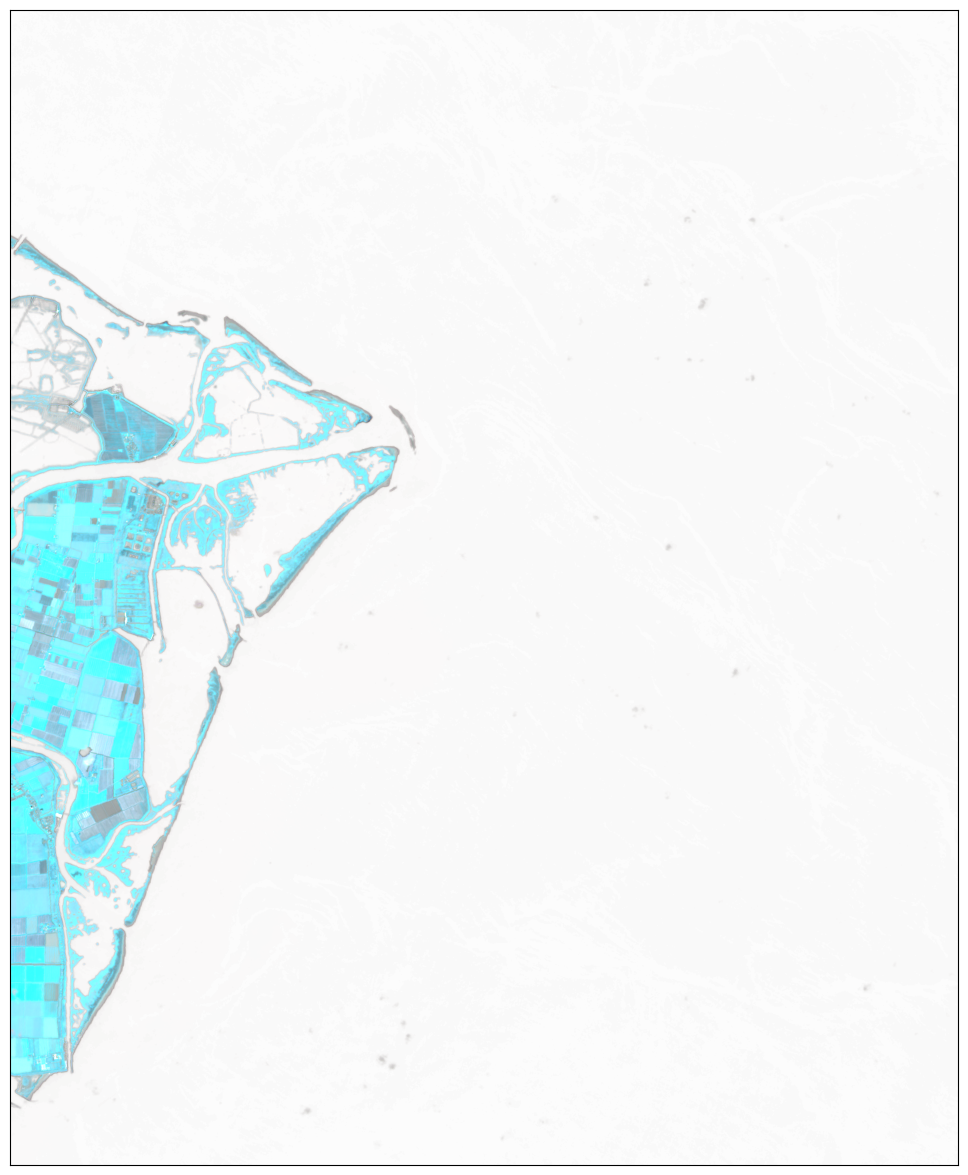

In [ ]:
plot_image(true_color_imgs[int(len(true_color_imgs)/2)], factor=6.5 / 500, clip_range=(0, 1))

# Remaining sections under construction.
Figure out why some images are 'cut off' (tiff vs jpg issue?)

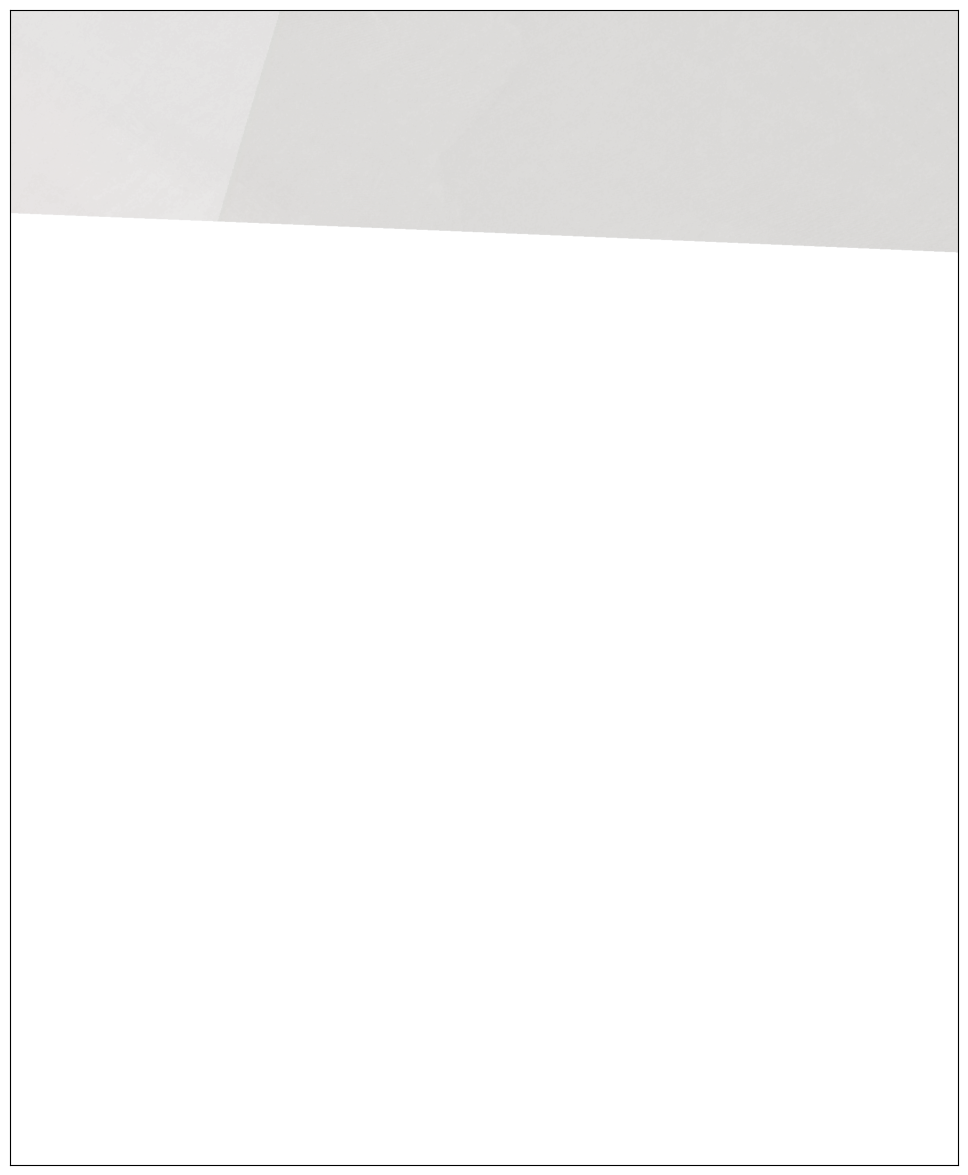

In [65]:
plot_image(true_color_imgs[-2], factor=6.5 / 500, clip_range=(0, 1))

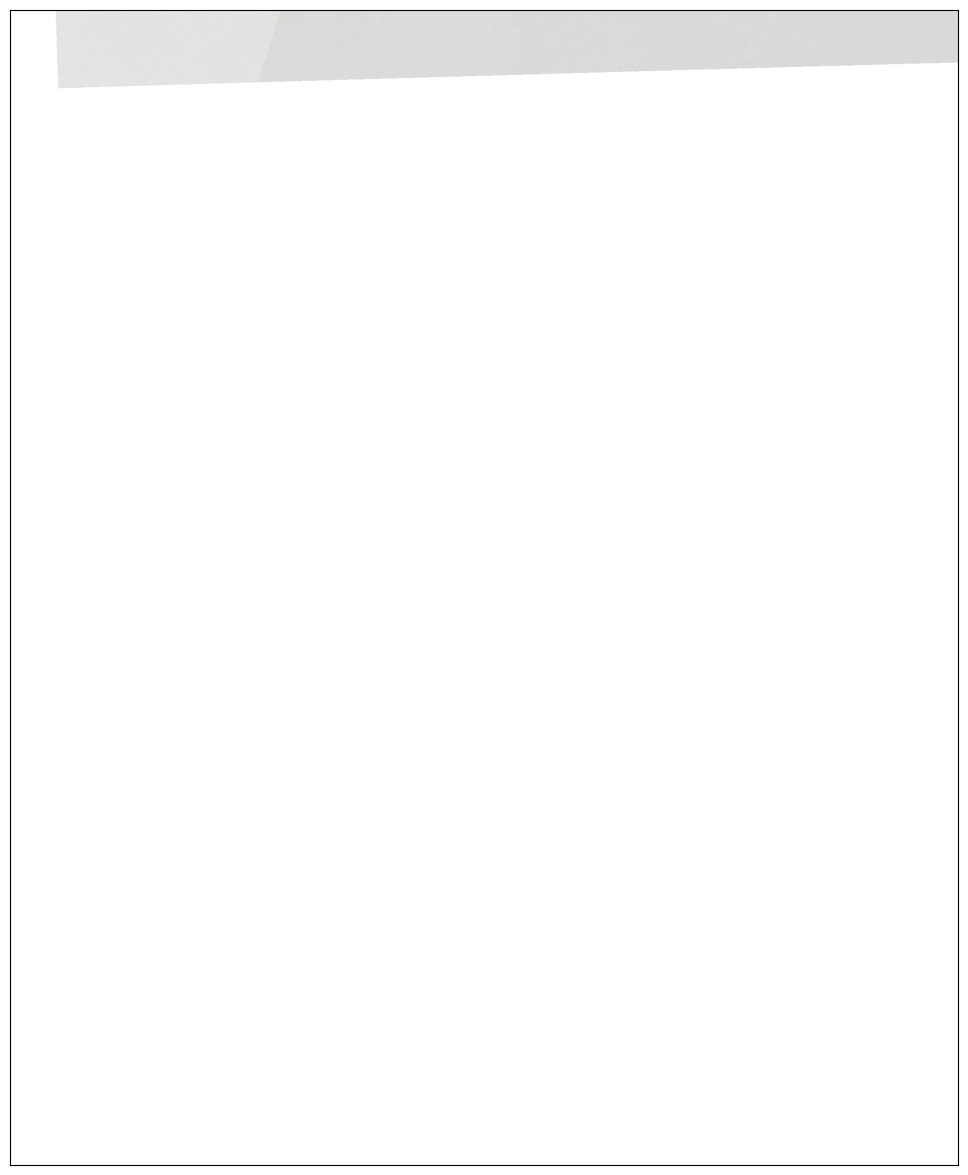

In [ ]:
plot_image(true_color_imgs[-1], factor=6.5 / 500, clip_range=(0, 1))

# Outstanding before complete:
- Create a function to save images/bands directly to kagglehub storage regardless where the code is ran, if possible, i.e. https://www.kaggle.com/datasets/sarahajbane/litter-windrows 
- Create proper true colour image from RGB bands and add transformations for NDVI and FDI from appropriate bands, creating appropriate outputs for MapMapper workflow and other model inputs output


# Notes for downloading directly to kaggle - in progress - not finished

## Iterate through the Sentinel Products identified and save them to kaggle hub 
### use this for batch downloads, i.e. to expand the dataset spatially & temporally - more months/other AOIs

This option now saves the retrieves Sentinal bands and eval script outputs directly to a central kaggle Dataset, which can be used as the input for other notebooks in the project (satellite correction and various models people are testing/evaluating), as well as for future use by the public

This section ensures all relevant Sentinel Products (bands/images) relating to the litter_rows will be saved to a public kagglehub [dataset]("https://www.kaggle.com/datasets/sarahajbane/litter-windrows") to have one stable centralised data storage location and streamline an input directory path for further use in the Satellite Detection algorithm project.  
(i.e. for satellite corrections, training, testing & validation of current and additional model versions), 
as well as an open source resource for future models or other open-source use cases for the public, similar to MARIDA dataset.

Step 1: Install the Kaggle API if not already installed. 
If you are using a virtual environment, you may need to install the Kaggle API with --user outside of it first for it to work
with a regular pip install command (i.e. pip install kaggle) within the venv afterwards

!pip install --user kaggle

make sure you have the /.kaggle/kaggle.json file in the correct location, i.e. your home directory or the current working directory if 
using colab or jupyter notebook

- Linux: $XDG_CONFIG_HOME/kaggle/kaggle.json (defaults to ~/.config/kaggle/kaggle.json). 
- The path ~/.kaggle/kaggle.json which was used by older versions of the tool is also still supported.




# Kagglehub instead of Kaggle API

In [28]:
# if you are workign on a local machine, add your working directory folder to the sys path
project_root = "/Users/sara_mac/Desktop/projects/plastic_detection/Sentinel2PlasticDetectionProject/task2-data-collection/" 
# if you are working on colab use the content (default) folder instead:
# project_root = "./content"
if project_root not in sys.path:
    sys.path.append(project_root)

In [29]:
data_dir = project_root + "kaggle_dataset/Po_River_July_2019/"
if data_dir not in sys.path:
    sys.path.append(data_dir)

In [ ]:
import kagglehub

# For example, to upload a new dataset (or version) at:
# - https://www.kaggle.com/datasets/bricevergnou/spotify-recommendation
# 
# You would use the following handle: `bricevergnou/spotify-recommendation`
handle = 'sarahajbane/litter_rows'
local_dataset_dir = {data_dir}

# Create a new dataset
kagglehub.dataset_upload(handle, local_dataset_dir)


In [ ]:

# You can then create a new version of this existing dataset and include version notes (optional).
kagglehub.dataset_upload(handle, local_dataset_dir, version_notes='improved data')

# You can also specify a list of patterns for files/dirs to ignore.
# These patterns are combined with `kagglehub.datasets.DEFAULT_IGNORE_PATTERNS` 
# to determine which files and directories to exclude. 
# To ignore entire directories, include a trailing slash (/) in the pattern.
kagglehub.dataset_upload(handle, local_dataset_dir, ignore_patterns=["original/", "*.tmp"])